In [1]:
% load_ext autoreload
% autoreload 2

In [10]:
import numpy as np
import pandas as pd
import xarray as xr

import datacube

In [2]:
dc = datacube.Datacube()
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://ceholden@:5432/datacube)>>>

In [4]:
obs = dc.product_observations()[0]

In [5]:
dc.list_products()

,name,description,platform,format,instrument,product_type,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,
1,ls5_ledaps_scene,Landsat 5 ESPA 30 meter,LANDSAT_5,GeoTiff,TM,ESPA,NaN,NaN,NaN,NaN
2,ls7_ledaps_scene,Landsat 7 ESPA 30 meter,LANDSAT_7,GeoTiff,ETM,ESPA,NaN,NaN,NaN,NaN
3,ls8_ledaps_scene,Landsat 8 ESPA 30 meter,LANDSAT_8,GeoTiff,OLI_TIRS,ESPA,NaN,NaN,NaN,NaN
4,ls8_ledaps_albers,"Landsat 8 ESPA products, 5000x5000 pixel 30m t...",LANDSAT_8,NetCDF,OLI_TIRS,ESPA,EPSG:5070,"[-30, 30]","[150000.0, 150000.0]","(y, x)"
5,ls7_ledaps_albers,"Landsat 7 ESPA products, 5000x5000 pixel 30m t...",LANDSAT_7,NetCDF,ETM,ESPA,EPSG:5070,"[-30, 30]","[150000.0, 150000.0]","(y, x)"


In [89]:
dc.list_measurements()

aliases  dtype  \
product           measurement                                                   
ls5_ledaps_scene  sr_band1                              [band_1, blue]  int16   
                  sr_band2                             [band_2, green]  int16   
                  sr_band3                               [band_3, red]  int16   
                  sr_band4                               [band_4, nir]  int16   
                  sr_band5                             [band_5, swir1]  int16   
                  sr_band7                             [band_7, swir2]  int16   
                  cfmask                                [mask, CFmask]  uint8   
                  cfmask_conf                            [mask_config]  uint8   
                  sr_adjacent_cloud_qa                [adjacent_cloud]  uint8   
                  sr_atmos_opacity      [atmospheric_opacity, opacity]  int16   
                  sr_cloud_qa                                  [cloud]  uint8   
                  sr_cloud_shadow_qa                    [cloud_shadow]  uint8   
                  sr_ddv_qa                                      [ddv]  uint8   
                  sr_fill_qa                                    [fill]  uint8   
                  sr_land_water_qa                        [land_water]  uint8   
                  sr_snow_qa                                    [snow]  uint8   
ls7_ledaps_scene  sr_band1                              [band_1, blue]  int16   
                  sr_band2                             [band_2, green]  int16   
                  sr_band3                               [band_3, red]  int16   
                  sr_band4                               [band_4, nir]  int16   
                  sr_band5                             [band_5, swir1]  int16   
                  sr_band7                             [band_7, swir2]  int16   
                  cfmask                                [mask, CFmask]  uint8   
                  cfmask_conf                            [mask_config]  uint8   
                  sr_adjacent_cloud_qa                [adjacent_cloud]  uint8   
                  sr_atmos_opacity      [atmospheric_opacity, opacity]  int16   
                  sr_cloud_qa                                  [cloud]  uint8   
                  sr_cloud_shadow_qa                    [cloud_shadow]  uint8   
                  sr_ddv_qa                                      [ddv]  uint8   
                  sr_fill_qa                                    [fill]  uint8   
...                                                                ...    ...   
ls8_ledaps_scene  sr_band7                             [band_7, swir2]  int16   
                  cfmask                                [mask, CFmask]  uint8   
                  cfmask_conf                            [mask_config]  uint8   
                  sr_cloud                                     [cloud]  uint8   
ls8_ledaps_albers coastal_aerosol            [band_1, coastal_aerosol]  int16   
                  blue                                  [band_2, blue]  int16   
                  green                                [band_3, green]  int16   
                  red                                    [band_4, red]  int16   
                  nir                                    [band_5, nir]  int16   
                  swir1                                [band_6, swir1]  int16   
                  swir2                                [band_7, swir2]  int16   
                  cf_mask                               [mask, CFmask]  int16   
                  cf_mask_conf                           [mask_config]  int16   
                  cloud                                        [cloud]  int16   
ls7_ledaps_albers blue                                  [band_1, blue]  int16   
                  green                                [band_2, green]  int16   
                  red                                    [band_3, red]  int16   
             

In [30]:
?xr.concat

In [15]:
?xr.merge

In [11]:
datasets = [
    dc.load(product=prod,
            product_type='ESPA',
            platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'],
            x=(-72, -71.90), y=(41., 41.10))
    for prod in ['ls7_ledaps_albers', 'ls8_ledaps_albers']
]

In [33]:
products = ['ls7_ledaps_albers', 'ls8_ledaps_albers']

# Find measurements common to all products
measurements = dc.list_measurements().reset_index()
measurements.index = measurements['product']
data_vars = set(measurements.loc[products[0], 'measurement'])
for prod in products[1:]:
    data_vars.intersection_update(measurements.loc[prod, 'measurement'])

# Read each product individually
datasets = []
for prod in products:
    ds = dc.load(product=prod,
                 product_type='ESPA',
                 platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'],
                 measurements=data_vars,
                 x=(-72, -71.90), y=(41., 41.10))
    ds['platform'] = ('time', np.repeat(prod, ds.time.size))
    datasets.append(ds)

# Concat along time
combined = xr.concat(datasets, dim='time')
# Sort by time
sorted_time = np.sort(combined.time)
combined.loc[dict(time=sorted_time)]

<xarray.Dataset>
Dimensions:       (time: 61, x: 364, y: 432)
Coordinates:
  * y             (y) float64 2.263e+06 2.263e+06 2.263e+06 2.263e+06 ...
  * x             (x) float64 1.979e+06 1.979e+06 1.979e+06 1.979e+06 ...
  * time          (time) datetime64[ns] 2013-04-16T15:28:55 ...
Data variables:
    red           (time, y, x) int16 115 107 106 102 106 111 112 112 108 107 ...
    swir1         (time, y, x) int16 116 100 98 100 99 98 103 107 105 107 ...
    swir2         (time, y, x) int16 107 100 93 93 98 99 103 104 105 103 104 ...
    nir           (time, y, x) int16 87 79 71 74 76 75 79 82 76 75 75 74 78 ...
    cf_mask_conf  (time, y, x) int16 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    green         (time, y, x) int16 246 235 236 239 235 231 237 245 238 237 ...
    blue          (time, y, x) int16 207 202 194 213 197 200 202 209 197 205 ...
    platform      (time) <U17 'ls8_ledaps_albers' 'ls8_ledaps_albers' ...
    cf_mask       (time, y, x) int16 1 1 1 1 1 1 1 1 1 1 1 1

In [34]:
combined

<xarray.Dataset>
Dimensions:       (time: 61, x: 364, y: 432)
Coordinates:
  * y             (y) float64 2.263e+06 2.263e+06 2.263e+06 2.263e+06 ...
  * x             (x) float64 1.979e+06 1.979e+06 1.979e+06 1.979e+06 ...
  * time          (time) datetime64[ns] 2013-10-01T15:22:55 ...
Data variables:
    red           (time, y, x) int16 20 -2 20 64 43 43 20 64 -9999 -2 87 20 ...
    swir1         (time, y, x) int16 8 8 8 -20 -20 8 8 8 -9999 8 8 8 -9999 ...
    swir2         (time, y, x) int16 50 50 -10 -10 19 80 19 -10 -9999 19 19 ...
    nir           (time, y, x) int16 -10 -42 23 23 -10 -42 -10 -10 -9999 23 ...
    cf_mask_conf  (time, y, x) int16 1 1 1 1 1 1 1 1 255 1 1 1 255 255 1 255 ...
    green         (time, y, x) int16 187 160 134 187 134 187 134 187 -9999 ...
    blue          (time, y, x) int16 235 186 186 211 186 235 211 161 -9999 ...
    platform      (time) <U17 'ls7_ledaps_albers' 'ls8_ledaps_albers' ...
    cf_mask       (time, y, x) int16 1 1 1 1 1 1 1 1 255 1 1 1 25

In [9]:
query = {
    
}

obs = []
for prod in products:
    obs.extend(
        dc.product_observations(product=prod, )
    )

group_by = datacube.api.query.group_by()
sources = dc.product_sources(sources, )

TypeError: product_sources() missing 3 required positional arguments: 'group_func', 'dimension', and 'units'

In [7]:
ds = dc.load(product='ls8_ledaps_albers', x=(-72, -71.90), y=(41., 41.10))

<IPython.core.display.Javascript object>


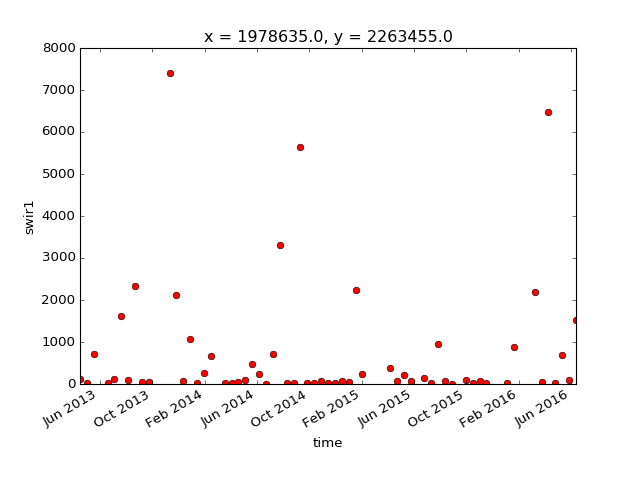

In [9]:
%matplotlib nbagg
ds['swir1'].isel(x=0, y=0).plot.line('ro')

In [10]:
from datacube.storage import masking
masking.get_flags_def(ds)

# pandas.DataFrame.from_dict(masking.get_flags_def(ds), orient='index')

clr = masking.make_mask(ds, cfmask='clear')

In [28]:
ds.x.size

364

In [40]:
%matplotlib nbagg
ds.where(clr)['swir1'].notnull().sum(dim='time')

<xarray.DataArray 'swir1' (y: 432, x: 364)>
array([[0, 0, 0, ..., 2, 3, 1],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 1, ..., 2, 2, 2],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]])
Coordinates:
  * x        (x) float64 1.979e+06 1.979e+06 1.979e+06 1.979e+06 1.979e+06 ...
  * y        (y) float64 2.263e+06 2.263e+06 2.263e+06 2.263e+06 2.263e+06 ...

<IPython.core.display.Javascript object>


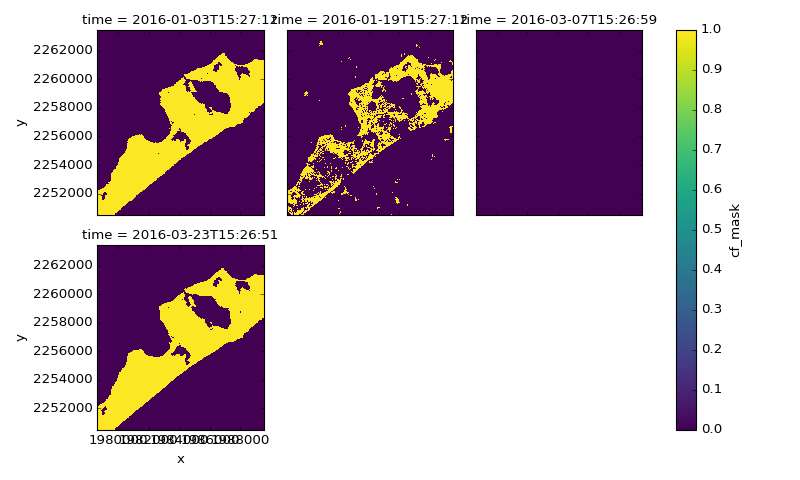

In [81]:
%matplotlib nbagg
clr.cf_mask.loc['2016-1':'2016-3'].plot(col='time', col_wrap=3)

In [67]:
gw = datacube.api.GridWorkflow(dc.index, product='ls8_ledaps_albers')
gw.list_tiles(product='ls8_ledaps_albers')
# gw.list_cells(product_type='ESPA', product='ls8_ledaps_albers')

defaultdict(dict,
            {(12,
              14,
              numpy.datetime64('2013-07-05T15:29:05.000000000')): {'geobox': GeoBox(5000, 5000, Affine(30.0, 0.0, 1800000.0,
                     0.0, -30.0, 2250000.0), EPSG:5070), 'sources': <xarray.DataArray (time: 1)>
              array([ (Dataset <id=67ce3c1e-0ffc-4f06-ae5d-4e5a1154c4ab type=ls8_ledaps_albers location=/projectnb/landsat/datasets/AGDC/TILES/LS8_OLI_LEDAPS/LS8_OLI_LEDAPS_3577_12_14_20130705152905000000.nc>,)], dtype=object)
              Coordinates:
                * time     (time) datetime64[ns] 2013-07-05T15:29:05},
             (12,
              14,
              numpy.datetime64('2013-07-21T15:29:03.000000000')): {'geobox': GeoBox(5000, 5000, Affine(30.0, 0.0, 1800000.0,
                     0.0, -30.0, 2250000.0), EPSG:5070), 'sources': <xarray.DataArray (time: 1)>
              array([ (Dataset <id=7e5ed3c4-86eb-415d-91a7-a9715b34089d type=ls8_ledaps_albers location=/projectnb/landsat/datasets/AGDC/TILE

In [68]:
?gw.load

In [93]:
gw.list_tiles(product_type='ESPA', product='ls8_ledaps_albers', platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'])

defaultdict(dict,
            {(12,
              14,
              numpy.datetime64('2013-07-05T15:29:05.000000000')): {'geobox': GeoBox(5000, 5000, Affine(30.0, 0.0, 1800000.0,
                     0.0, -30.0, 2250000.0), EPSG:5070), 'sources': <xarray.DataArray (time: 1)>
              array([ (Dataset <id=67ce3c1e-0ffc-4f06-ae5d-4e5a1154c4ab type=ls8_ledaps_albers location=/projectnb/landsat/datasets/AGDC/TILES/LS8_OLI_LEDAPS/LS8_OLI_LEDAPS_3577_12_14_20130705152905000000.nc>,)], dtype=object)
              Coordinates:
                * time     (time) datetime64[ns] 2013-07-05T15:29:05},
             (12,
              14,
              numpy.datetime64('2013-07-21T15:29:03.000000000')): {'geobox': GeoBox(5000, 5000, Affine(30.0, 0.0, 1800000.0,
                     0.0, -30.0, 2250000.0), EPSG:5070), 'sources': <xarray.DataArray (time: 1)>
              array([ (Dataset <id=7e5ed3c4-86eb-415d-91a7-a9715b34089d type=ls8_ledaps_albers location=/projectnb/landsat/datasets/AGDC/TILE

In [87]:
dataset.metadata_doc['platform']

{'code': 'LANDSAT_8'}

In [58]:
TILE = (14, 14)

cell_obs = gw.cell_observations(product='ls8_ledaps_albers')
datasets = cell_obs[TILE]['datasets']

# Sort by center time
datasets = sorted(datasets, key=lambda d: d.center_time)

In [65]:
from osgeo import gdal

p = str(dataset.local_path)

for name, md in dataset.measurements.items():
    sds_file = 'NETCDF:"{file}":{measurement}'.format(file=p, measurement=md['layer'])
    
    _sds = gdal.Open(sds_file)
    print(_sds.GetMetadata_Dict())

{'NC_GLOBAL#history': "NetCDF-CF file created by datacube version '1.1.4' at 20160714.", 'time#calendar': 'standard', 'NC_GLOBAL#title': 'Boston University Data Cube Landsat Surface Reflectance', 'crs#false_easting': '0', 'crs#standard_parallel': '{29.5,45.5}', 'time#long_name': 'Time, unix time-stamp', 'NC_GLOBAL#keywords_vocabulary': 'GCMD', 'NC_GLOBAL#institution': 'Boston University', 'y#standard_name': 'projection_y_coordinate', 'NETCDF_DIM_time_VALUES': '1461511597', 'NC_GLOBAL#product_version': '2.0.0', 'y#long_name': 'y coordinate of projection', 'NC_GLOBAL#project': 'BU', 'crs#crs_wkt': 'PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1